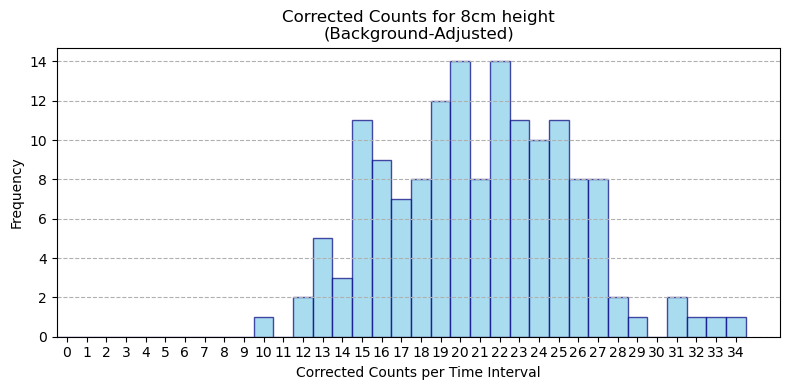

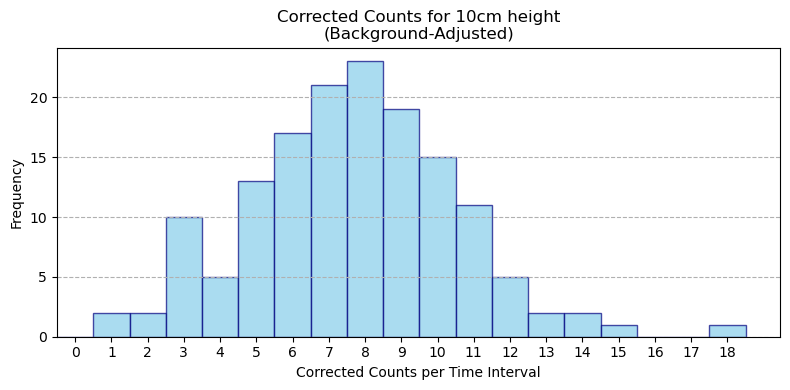

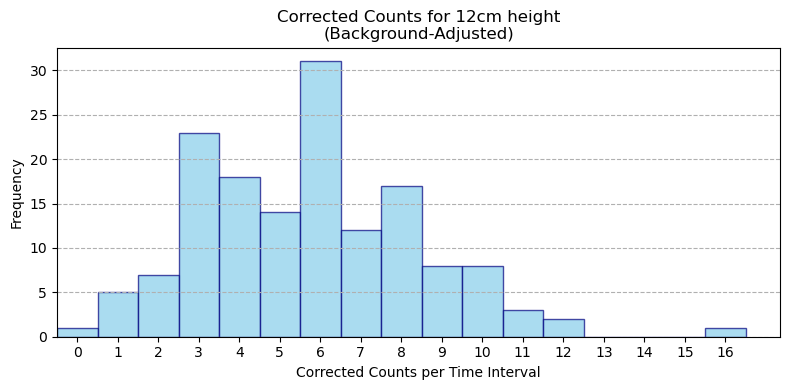

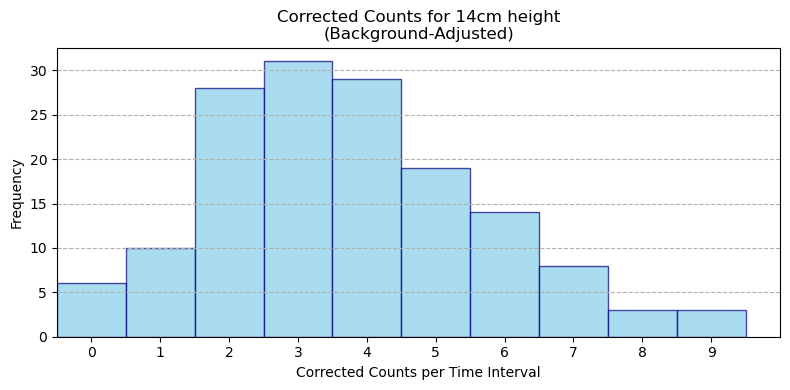

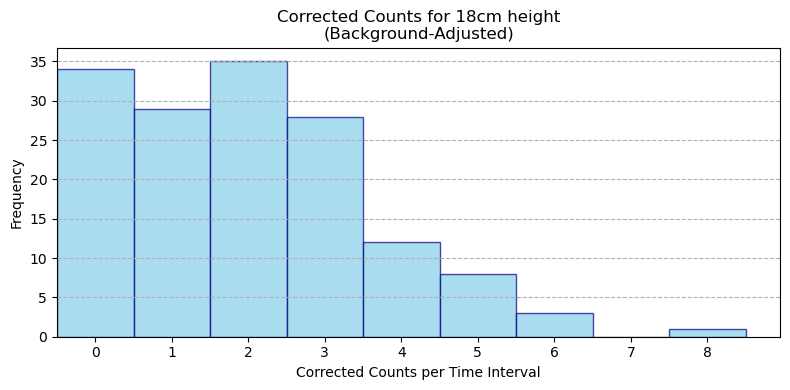

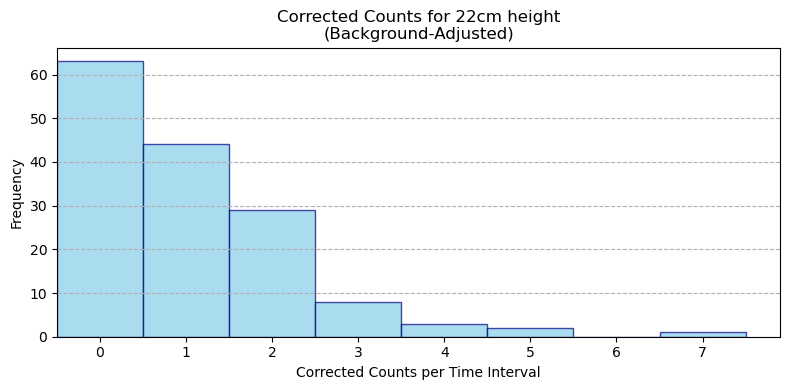

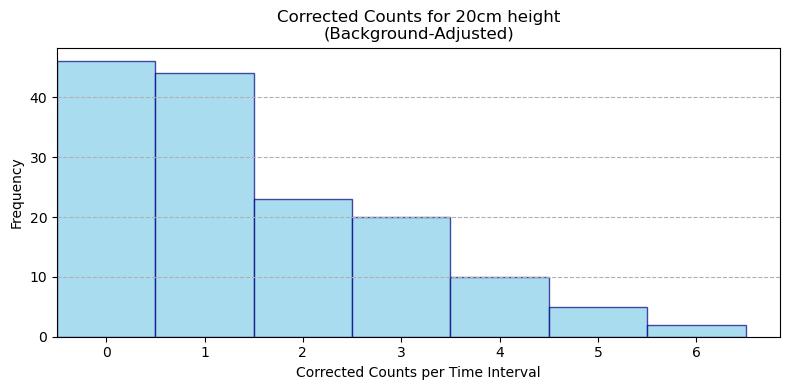

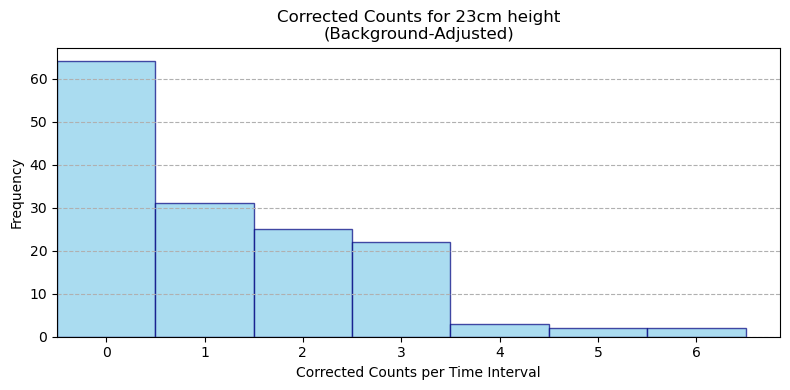

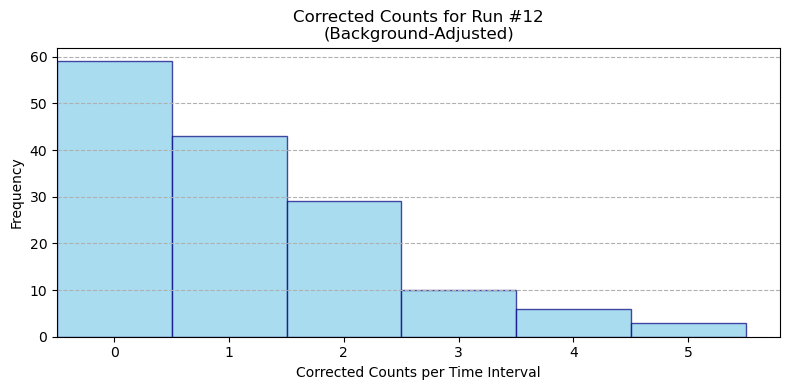

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv('/Users/willgray/Downloads/simulated_geiger_data.csv')

# Parse trials from column headers
trials = {}
for col in df.columns:
    if col.startswith('Time (s)'):
        trial_name = col.split('Time (s) ')[1].strip()
        trials[trial_name] = {'time_col': col, 'counts_col': None}
    elif col.startswith('Geiger Counts (counts/sample)'):
        trial_name = col.split('Geiger Counts (counts/sample) ')[1].strip()
        trials[trial_name] = {'time_col': None, 'counts_col': col}

# Extract background counts and compute mean
bg_trial = trials.get('background')
if not bg_trial or not bg_trial['counts_col']:
    raise ValueError("Background data missing or improperly formatted.")
bg_counts = df[bg_trial['counts_col']].dropna()
bg_mean = bg_counts.mean()

# Process each trial (excluding background)
for trial_name in trials:
    if trial_name == 'background':
        continue
    trial = trials[trial_name]
    if not trial['counts_col']:
        print(f"Skipping {trial_name} (missing counts column)")
        continue
    
    # Get counts and correct for background
    counts_data = df[trial['counts_col']].dropna()
    corrected_counts = (counts_data - bg_mean).clip(lower=0)  # Clip negative values
    
    # Calculate bins (aligned to integers starting from 0)
    max_val = corrected_counts.max()
    bins = np.arange(0, np.ceil(max_val) + 1, 1)
    
    # Plotting
    plt.figure(figsize=(8, 4))
    plt.hist(
        corrected_counts,
        bins=bins,
        alpha=0.7,
        color='skyblue',
        edgecolor="navy",
        density=False
    )
    
    # Label bins at integer centers
    plt.xticks(
        bins[:-1] + 0.5,  # Center labels between bin edges
        [str(int(x)) for x in bins[:-1]]  # Integer labels
    )
    
    plt.xlabel("Corrected Counts per Time Interval")
    plt.ylabel("Frequency")
    plt.title(f"Corrected Counts for {trial_name}\n(Background-Adjusted)")
    plt.grid(axis='y', linestyle='--')
    plt.xlim(left=0)  # Ensure x-axis starts at 0
    plt.tight_layout()
    plt.show()

Trial '8cm height': μ = 21.31


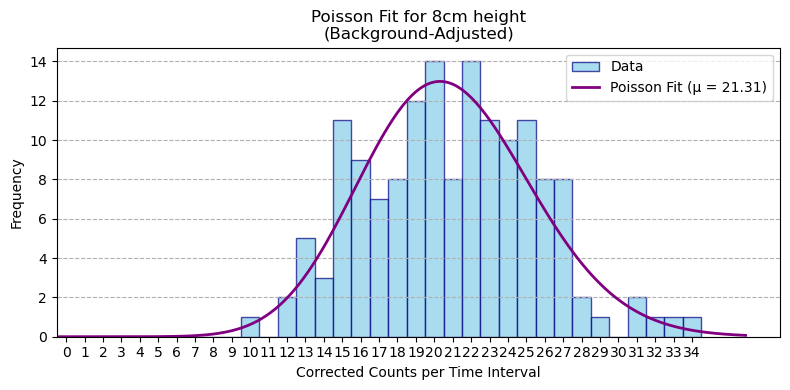

Trial '10cm height': μ = 8.08


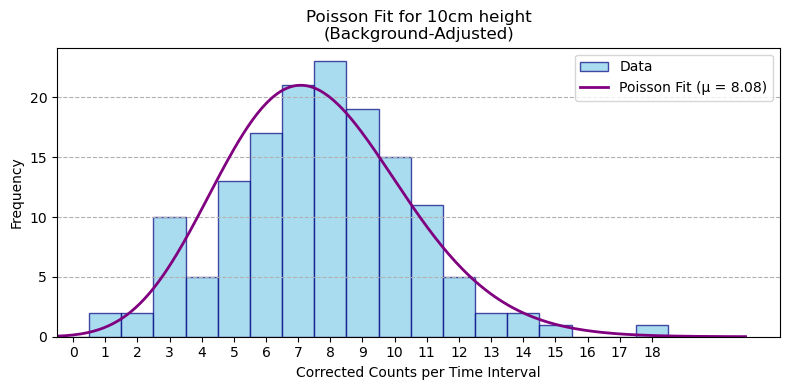

Trial '12cm height': μ = 6.15


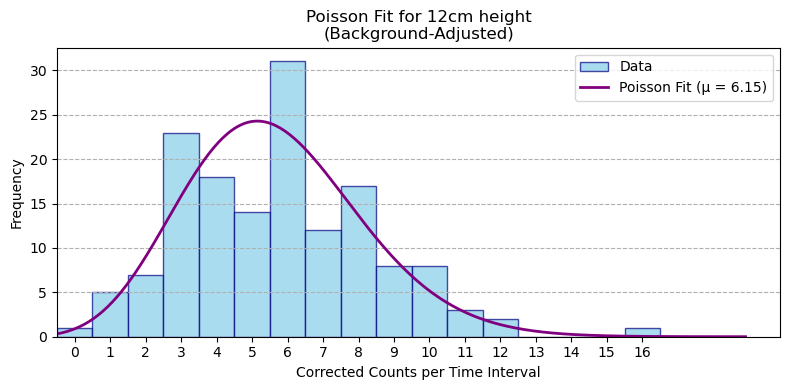

Trial '14cm height': μ = 4.12


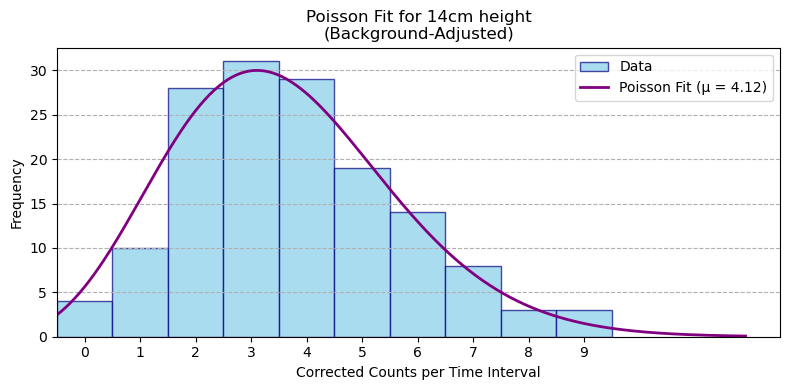

Trial '18cm height': μ = 2.32


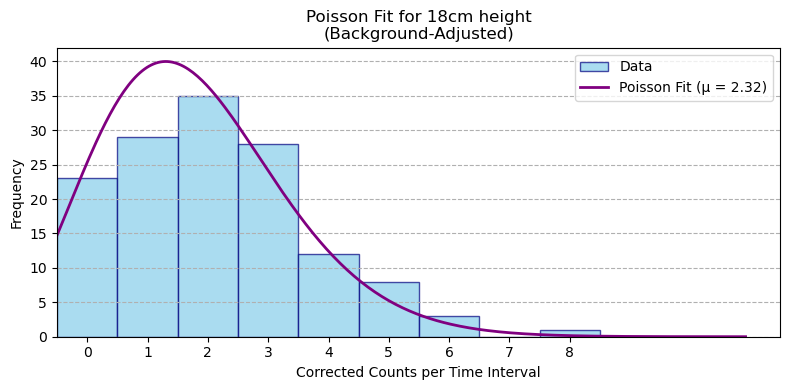

Trial '22cm height': μ = 1.27


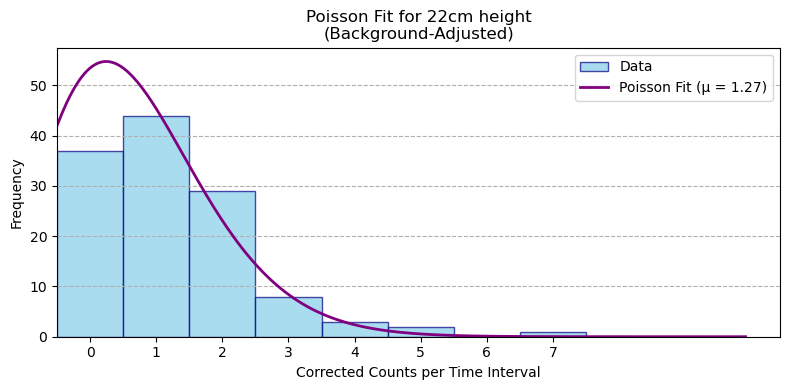

Trial '20cm height': μ = 1.83


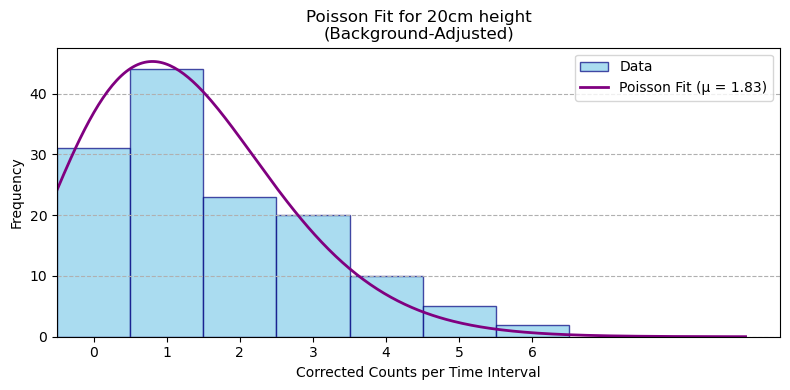

Trial '23cm height': μ = 1.49


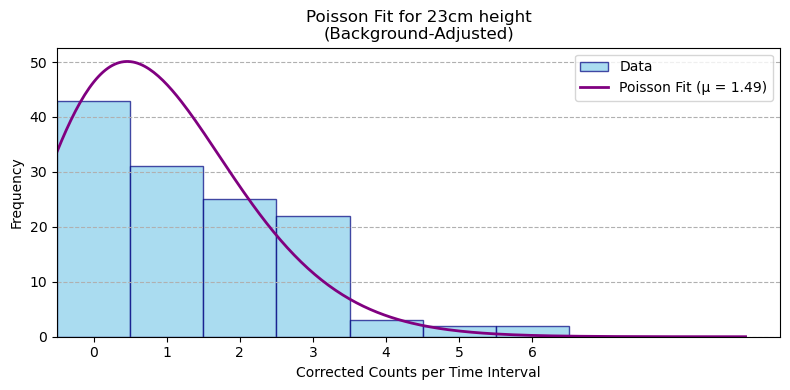

Trial 'Run #12': μ = 1.42


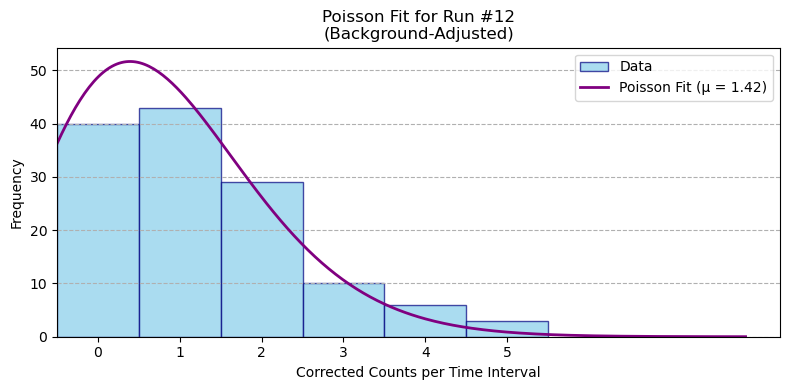

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import gamma

df = pd.read_csv('/Users/willgray/Downloads/simulated_geiger_data.csv')


trials = {}
for col in df.columns:
    if col.startswith('Time (s)'):
        trial_name = col.split('Time (s) ')[1].strip()
        trials[trial_name] = {'time_col': col, 'counts_col': None}
    elif col.startswith('Geiger Counts (counts/sample)'):
        trial_name = col.split('Geiger Counts (counts/sample) ')[1].strip()
        trials[trial_name] = {'time_col': None, 'counts_col': col}

bg_trial = trials.get('background')
if not bg_trial or not bg_trial['counts_col']:
    raise ValueError("Background data missing or improperly formatted.")
bg_counts = df[bg_trial['counts_col']].dropna()
bg_mean = bg_counts.mean()

for trial_name in trials:
    if trial_name == 'background':
        continue
    trial = trials[trial_name]
    if not trial['counts_col']:
        print(f"Skipping {trial_name} (missing counts column)")
        continue
    
    counts_data = df[trial['counts_col']].dropna()
    corrected_counts = counts_data - bg_mean
    
    mu = corrected_counts.mean()
    print(f"Trial '{trial_name}': μ = {mu:.2f}")
    
    max_val = corrected_counts.max()
    bins = np.arange(0, np.ceil(max_val) + 1, 1)
    
    x_vals = np.linspace(0, max_val + 3, 300)
    
    poisson_pmf = (mu**x_vals * np.exp(-mu)) / gamma(x_vals + 1)
    
    scaled_pmf = poisson_pmf * len(corrected_counts)
    
    plt.figure(figsize=(8, 4))
    plt.hist(
        corrected_counts,
        bins=bins,
        alpha=0.7,
        color = 'skyblue',
        edgecolor="navy",
        density=False,
        label='Data'
    )
    
    plt.plot(
        x_vals,
        scaled_pmf,
        color='purple',
        linewidth=2,
        label=f'Poisson Fit (μ = {mu:.2f})'
    )
    
    plt.xticks(
        bins[:-1] + 0.5,
        [str(int(x)) for x in bins[:-1]]
    )
    plt.xlabel("Corrected Counts per Time Interval")
    plt.ylabel("Frequency")
    plt.title(f"Poisson Fit for {trial_name}\n(Background-Adjusted)")
    plt.grid(axis='y', linestyle='--')
    plt.xlim(left=0)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import gamma
from scipy.stats import chisquare

df = pd.read_csv('/Users/willgray/Downloads/simulated_geiger_data.csv', header=0)

# Parse trials correctly
trials = {}
for col in df.columns:
    # Handle Time columns
    if "Time (s)" in col:
        trial_name = col.replace("Time (s)", "").strip()
        if trial_name not in trials:
            trials[trial_name] = {"time_col": col, "counts_col": None}
        else:
            trials[trial_name]["time_col"] = col
    # Handle Geiger Counts columns
    elif "Geiger Counts (counts/sample)" in col:
        trial_name = col.replace("Geiger Counts (counts/sample)", "").strip()
        if trial_name not in trials:
            trials[trial_name] = {"time_col": None, "counts_col": col}
        else:
            trials[trial_name]["counts_col"] = col

dif "background" not in trials:
    raise ValueError("Background trial missing in data")

bg_counts = df[trials["background"]["counts_col"]].dropna()
bg_mean = bg_counts.mean()

results = []
for trial_name in trials:
    if trial_name == "background":
        continue
    
    trial = trials[trial_name]
    if not trial["counts_col"]:
        print(f"Skipping {trial_name} (no counts column)")
        continue
    
    counts_col = trial["counts_col"]
    if not isinstance(counts_col, str):
        print(f"Skipping {trial_name} (invalid counts column type: {type(counts_col)})")
        continue
    
    counts_data = df[counts_col].dropna()
    corrected_counts = (counts_data - bg_mean)
    
    if len(corrected_counts) == 0 or corrected_counts.sum() == 0:
        print(f"Skipping {trial_name} (no valid counts)")
        continue
    
    mu = corrected_counts.mean()
    max_val = int(corrected_counts.max())
    bins = np.arange(0, max_val + 2)
    observed, _ = np.histogram(corrected_counts, bins=bins)
    
    x_integers = np.arange(0, max_val + 1)
    poisson_probs = [(mu**x * np.exp(-mu)) / gamma(x + 1) for x in x_integers]
    total_p = sum(poisson_probs)
    remaining_p = max(0, 1 - total_p)
    expected = [p * len(corrected_counts) for p in poisson_probs] + [remaining_p * len(corrected_counts)]
    
    observed = np.append(observed, 0)  # Add overflow bin
    
    valid = np.array(expected) >= 1
    observed_filtered = observed[valid]
    expected_filtered = np.array(expected)[valid]
    
    if expected_filtered.sum() > 0:
        expected_filtered = expected_filtered * (observed_filtered.sum() / expected_filtered.sum())
    
    #chi squared
    try:
        chi2, p = chisquare(observed_filtered, f_exp=expected_filtered, ddof=1)
        dof = len(observed_filtered) - 2
        results.append([trial_name, mu, chi2, p, dof])
    except Exception as e:
        results.append([trial_name, mu, np.nan, str(e), np.nan])

# Print results
print("\nChi-Squared Results:")
print("=" * 65)
print(f"{'Trial':<20} | {'μ':<8} | {'χ²':<10} | {'p-value':<12} | {'DoF'}")
print("-" * 65)
for row in results:
    print(f"{row[0]:<20} | {row[1]:.2f} | {row[2]:<10.2f} | {row[3]:<12.4f} | {row[4]}")



Chi-Squared Results:
Trial                | μ        | χ²         | p-value      | DoF
-----------------------------------------------------------------
8cm height           | 21.31 | 19.08      | 0.4518       | 19
10cm height          | 8.08 | 13.20      | 0.3548       | 12
12cm height          | 6.15 | 25.07      | 0.0052       | 10
14cm height          | 4.12 | 8.06       | 0.5284       | 9
18cm height          | 2.32 | 8.96       | 0.1757       | 6
22cm height          | 1.27 | 2.76       | 0.5985       | 4
20cm height          | 1.83 | 10.59      | 0.0601       | 5
23cm height          | 1.49 | 15.73      | 0.0034       | 4
Run #12              | 1.42 | 5.76       | 0.2177       | 4
